# Снижение размерности

In [2]:
import os
import pandas as pd

In [2]:
dirnames = ['Фанфик', 'Философия', 'Фэнтези']

In [3]:
curr_dir = os.getcwd()
filepaths = []
for dirname in dirnames:
    filepath = os.path.join(curr_dir, dirname)
    for root, dirs, files in os.walk(filepath):
        for name in files[:150]:
            filepaths.append(os.path.join(root, name))

In [4]:
df = pd.DataFrame(columns=['text', 'filepath', 'genre'])

In [5]:
df['filepath'] = filepaths

In [6]:
for i, row in df.iterrows():
    if 'Философия' in row['filepath']:
        row['genre'] = 'философия'
    elif 'Фанфик' in row['filepath']:
        row['genre'] = 'фанфик'
    else:
        row['genre'] = 'фэнтази'

In [3]:
import nltk
from nltk.corpus import stopwords
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS
from pymorphy2 import MorphAnalyzer
import pymorphy2

In [11]:
nlp = Russian()
nlp.max_length = 2500000
russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
morph = pymorphy2.MorphAnalyzer()

def preproc(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
        # убираем стоп-слова
        text = ' '.join([word for word in text.lower().split() if word not in stopwords.words('russian')])
        # разбиваем на токены
        doc = nlp(text)
        tokenized = [token.text for token in doc if token.text not in ',.!?-();:""«»—_–#' and '.' not in token.text]
        # лемматизируем
        return ' '.join([morph.parse(word)[0].normal_form for word in tokenized])

In [9]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas('PROGRESS>>>')

<ipython-input-9-33bc34927f9c>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
C:\Users\vital\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
df['text'] = df['filepath'].progress_apply(preproc)

In [14]:
df.head()

,text,filepath,genre
0,ленточка фанфик роман андрей круз земля лишний...,C:\Users\vital\Фанфик\kowalenko_e_blentochka2.txt,фанфик
1,mass effect while the reaper назвый mass effec...,C:\Users\vital\Фанфик\kowizhenko_w_wmasseffect...,фанфик
2,дмитрий крам s t i k s подкидыш улья андрей пр...,C:\Users\vital\Фанфик\kram_dhivepodkidyshiulxj...,фанфик
3,дмитрий крам исчезнуть клан фанфик играть жить...,C:\Users\vital\Фанфик\kram_discheznuwshijklan.txt,фанфик
4,содержание часть 1 акклиматиазия часть 2 полёт...,C:\Users\vital\Фанфик\krasnoperowa_ahp_peste.txt,фанфик


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
vectorizer = TfidfVectorizer(max_features=25000)

In [112]:
X = vectorizer.fit_transform(df['text'])

In [114]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [115]:
pca = PCA(n_components=2)

In [116]:
principalComponents = pca.fit_transform(X.todense())
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [117]:
df_final = pd.concat([df_pca, df[['genre']]], axis = 1)

In [118]:
df_final.head()

,principal component 1,principal component 2,genre
0,0.132489,-0.065356,фанфик
1,-0.287312,-0.037368,фанфик
2,0.014455,0.030648,фанфик
3,0.278568,0.027481,фанфик
4,-0.271592,0.019683,фанфик


Визуализация документов на плоскости методом главных компонент снижения размерности Bag-of-Words векторов

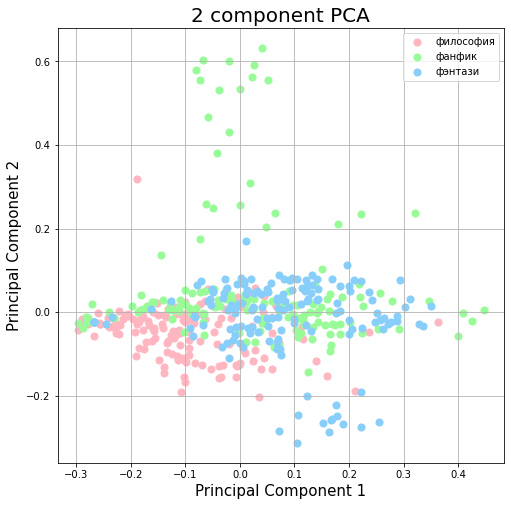

In [119]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['философия', 'фанфик', 'фэнтази']
colors = ['lightpink', 'palegreen', 'lightskyblue']
for target, color in zip(targets,colors):
    indicesToKeep = df_final['genre'] == target
    ax.scatter(df_final.loc[indicesToKeep, 'principal component 1']
               , df_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Визуализация документов на плоскости методом t-SNE снижения размерности Bag-of-Words векторов.

In [105]:
from sklearn.manifold import TSNE

In [120]:
tsne = TSNE(n_components=2).fit_transform(X.todense())

In [121]:
df_tsne = pd.DataFrame(data = tsne
             , columns = ['principal component 1', 'principal component 2'])

In [122]:
tsne_final = pd.concat([df_tsne, df[['genre']]], axis = 1)

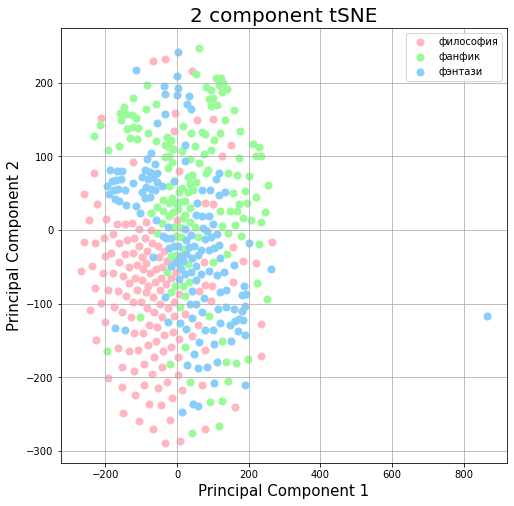

In [123]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component tSNE', fontsize = 20)
targets = ['философия', 'фанфик', 'фэнтази']
colors = ['lightpink', 'palegreen', 'lightskyblue']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_final['genre'] == target
    ax.scatter(tsne_final.loc[indicesToKeep, 'principal component 1']
               , tsne_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Тематическое моделирование

In [5]:
df_emails = pd.read_csv('Emails.csv')

In [6]:
df_emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [7]:
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string
import re

In [8]:
def preproc_eng(text):
    text = str(text)
    lemmatizer = WordNetLemmatizer()
    clean_text = ' '.join([word for word in text.lower().split()])
    # убираем знаки препинания
    clean_text = clean_text.translate(str.maketrans(dict.fromkeys(string.punctuation))).split()
    clean_text = [re.sub('[«|»|…]', '', word) for word in clean_text]
    clean_text = [re.sub('\d', '', word) for word in clean_text]
    # лемматизируем
    clean_text = ' '.join([lemmatizer.lemmatize(word) for word in clean_text])
    clean_text = clean_text.replace('\n', '')
    clean_text = clean_text.replace('nan', '')
    # убираем стоп-слова
    clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords.words('english') and len(word) > 2])
    return clean_text

In [10]:
emails_corpus = df_emails['ExtractedBodyText'].progress_apply(preproc_eng)

**Для CountVectorizer**

In [11]:
vec = CountVectorizer()
X = vec.fit_transform(emails_corpus)
vocab = vec.get_feature_names()

In [12]:
import gensim
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from scipy.sparse import csc

In [13]:
vocab_dict = dict([(i, s) for i, s in enumerate(vocab)])

In [14]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)

In [15]:
lda = LdaModel(matutils.Sparse2Corpus(X.T), num_topics=5, passes=20, id2word=vocab_dict)

In [17]:
topics = lda.print_topics(num_topics=-1, num_words=15)
for topic in topics:
    print(topic)

(0, '0.013*"state" + 0.005*"israel" + 0.005*"american" + 0.004*"security" + 0.004*"government" + 0.004*"department" + 0.004*"would" + 0.004*"new" + 0.004*"united" + 0.004*"said" + 0.004*"israeli" + 0.004*"president" + 0.003*"people" + 0.003*"one" + 0.003*"world"')
(1, '0.045*"secretary" + 0.042*"office" + 0.021*"state" + 0.021*"meeting" + 0.020*"room" + 0.016*"department" + 0.014*"arrive" + 0.014*"route" + 0.014*"depart" + 0.012*"private" + 0.011*"conference" + 0.011*"residence" + 0.010*"time" + 0.008*"staff" + 0.008*"daily"')
(2, '0.006*"china" + 0.005*"woman" + 0.004*"year" + 0.004*"would" + 0.004*"one" + 0.004*"people" + 0.004*"work" + 0.003*"haiti" + 0.003*"country" + 0.003*"say" + 0.003*"group" + 0.003*"also" + 0.003*"could" + 0.003*"time" + 0.003*"school"')
(3, '0.016*"call" + 0.013*"fyi" + 0.009*"see" + 0.008*"get" + 0.008*"know" + 0.007*"tomorrow" + 0.007*"want" + 0.006*"also" + 0.006*"today" + 0.006*"work" + 0.006*"cheryl" + 0.005*"good" + 0.005*"think" + 0.005*"would" + 0.005

- **тема 0:** переписки о американо-израильских отношениях
- **тема 1:** переписки с канцелярией государственного секретаря о времени и месте проведения встреч/конференций
- **тема 2:** ??? переписки о внешней политике (названия стран Китай, Гаити)
- **тема 3:** переписки-распоряжения и оповещения (много глаголов и наречий времени)
- **тема 4:** переписки об Обаме, президентских выборах и политических партиях

In [18]:
from pyLDAvis import gensim
import pyLDAvis

In [19]:
pyLDAvis.enable_notebook()

In [20]:
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

C:\Users\vital\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.066358 -0.083048       1        1  28.636864
2      0.082409 -0.087860       2        1  27.263447
0      0.048046 -0.093188       3        1  26.369238
3      0.107648  0.236917       4        1  11.444394
1     -0.304460  0.027179       5        1   6.286050, topic_info=      Category         Freq        Term        Total  loglift  logprob
21025  Default  1206.000000   secretary  1206.000000  30.0000  30.0000
16425  Default  1043.000000      office  1043.000000  29.0000  29.0000
22469  Default  1743.000000       state  1743.000000  28.0000  28.0000
14685  Default   702.000000     meeting   702.000000  27.0000  27.0000
5986   Default   691.000000  department   691.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
18299   Topic5    87.431595       press   254.494720   1.6984  -5.4352
8952    Topic5   109.289627     foreign   515.801941   1.2151  -5.2120
22183   Topic5    80.900543     special   203.506943   1.8444  -5.5128
25979   Topic5    95.264992       white   393.110474   1.3494  -5.3494
3323    Topic5    78.916161        call   767.805298   0.4917  -5.5377

[389 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
42         4  0.993386           abedin
45         4  0.983178  abedinhstategov
327        2  0.974186    administrator
405        5  0.938843              afb
438        2  0.005311           afghan
...      ...       ...              ...
26601      2  0.985966              yeo
26606      1  0.155775              yes
26606      3  0.055634              yes
26606      4  0.784437              yes
26649      5  0.969177    yorklaguardia

[779 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 2])

**Для TfIdf Vectorizer**

In [21]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(emails_corpus)
vocab = vec.get_feature_names()

In [22]:
vocab_dict = dict([(i, s) for i, s in enumerate(vocab)])

In [23]:
import gensim
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from scipy.sparse import csc

In [24]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)

In [28]:
lda_tfidf = LdaModel(matutils.Sparse2Corpus(X.T), num_topics=5, passes=10, id2word=vocab_dict)

In [29]:
topics = lda_tfidf.print_topics(num_topics=-1, num_words=15)
for topic in topics:
    print(topic)

(0, '0.007*"call" + 0.004*"see" + 0.003*"get" + 0.003*"know" + 0.003*"tomorrow" + 0.003*"talk" + 0.003*"state" + 0.003*"would" + 0.003*"good" + 0.003*"time" + 0.003*"work" + 0.003*"also" + 0.003*"want" + 0.003*"today" + 0.002*"let"')
(1, '0.005*"thx" + 0.003*"importance" + 0.003*"high" + 0.002*"traffic" + 0.002*"remind" + 0.001*"yeah" + 0.001*"sigh" + 0.001*"isabelle" + 0.001*"tues" + 0.001*"mashabane" + 0.001*"discus" + 0.001*"bader" + 0.001*"confidential" + 0.001*"marianne" + 0.001*"recd"')
(2, '0.003*"roger" + 0.002*"min" + 0.002*"declassify" + 0.002*"nice" + 0.001*"course" + 0.001*"ellen" + 0.001*"scroll" + 0.001*"noon" + 0.001*"problem" + 0.001*"reason" + 0.001*"count" + 0.001*"thnx" + 0.001*"messa" + 0.001*"yang" + 0.001*"rch"')
(3, '0.072*"fyi" + 0.006*"yes" + 0.006*"mill" + 0.006*"cheryl" + 0.006*"millscdstategov" + 0.004*"hillary" + 0.004*"abedinhstategov" + 0.003*"abedin" + 0.003*"hrodclintonemailcom" + 0.003*"huma" + 0.002*"yep" + 0.002*"sullivanjjstategov" + 0.002*"october"

LDA на TfIdfVectorizer представлениях показывает неравномерно распределенные и менее осмысленные результаты (в визуализации ниже представлено, что первая тема содержит около 60% токенов). Все темы содержат подходят под описание обычной деловой переписки с обсуждением встреч и звонков, вот некоторые закономерности, которые можно попытаться выделить:

- тема 0: письма с выражением просьбы или приказа (больше глаголов)
- тема 3: переписка с Черил Миллс
- тема 4: письма с конкретным назначением печати в офис секретаря

In [30]:
pyLDAvis.gensim.prepare(lda_tfidf, corpus, dictionary)

C:\Users\vital\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.178441  0.000738       1        1  59.889023
2      0.045273 -0.014374       2        1  12.687819
4      0.042337 -0.030256       3        1  10.244827
1      0.044449 -0.014334       4        1  10.060226
3      0.046382  0.058225       5        1   7.118108, topic_info=      Category        Freq       Term       Total  loglift  logprob
9346   Default  115.000000        fyi  115.000000  30.0000  30.0000
18375  Default   38.000000      print   38.000000  29.0000  29.0000
17821  Default   42.000000        pls   42.000000  28.0000  28.0000
26606  Default   36.000000        yes   36.000000  27.0000  27.0000
23796  Default   43.000000        thx   43.000000  26.0000  26.0000
...        ...         ...        ...         ...      ...      ...
14522   Topic5    2.760102        may   23.227425   0.5125  -6.3574
22965   Topic5    2.453890     sunday   20.026674   0.5431  -6.4750
15225   Topic5    2.482948     monday   23.665545   0.3880  -6.4633
12753   Topic5    2.182331       june   11.487982   0.9816  -6.5923
21226   Topic5    2.137947  september   12.662287   0.8637  -6.6129

[246 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
42         1  0.694752           abedin
42         5  0.289480           abedin
44         5  0.901296          abedinh
45         5  0.906443  abedinhstategov
327        4  0.852411    administrator
...      ...       ...              ...
26604      5  0.931765              yep
26606      1  0.718902              yes
26606      5  0.276501              yes
26654      2  0.892121           youand
26690      4  0.819356              yup

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])